In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(100000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Training Theta Shape: torch.Size([100000, 4])
Training Data Shape: torch.Size([100000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])
Normalization and denormalization process is consistent for both parameters and observed data.


In [5]:
gk_dist.get_info()

true_params is on device: cpu
theta_normalizer uses device: cpu
data_normalizer uses device: cpu


In [6]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([100000, 4]), torch.Size([100000, 1000]))

# Initialise the Model

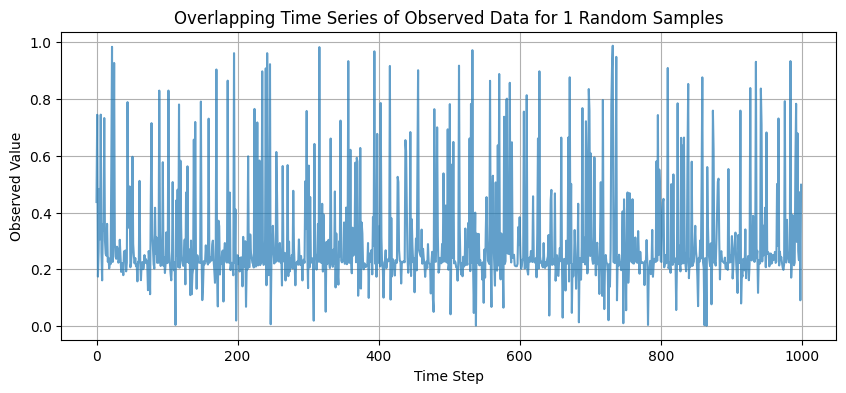

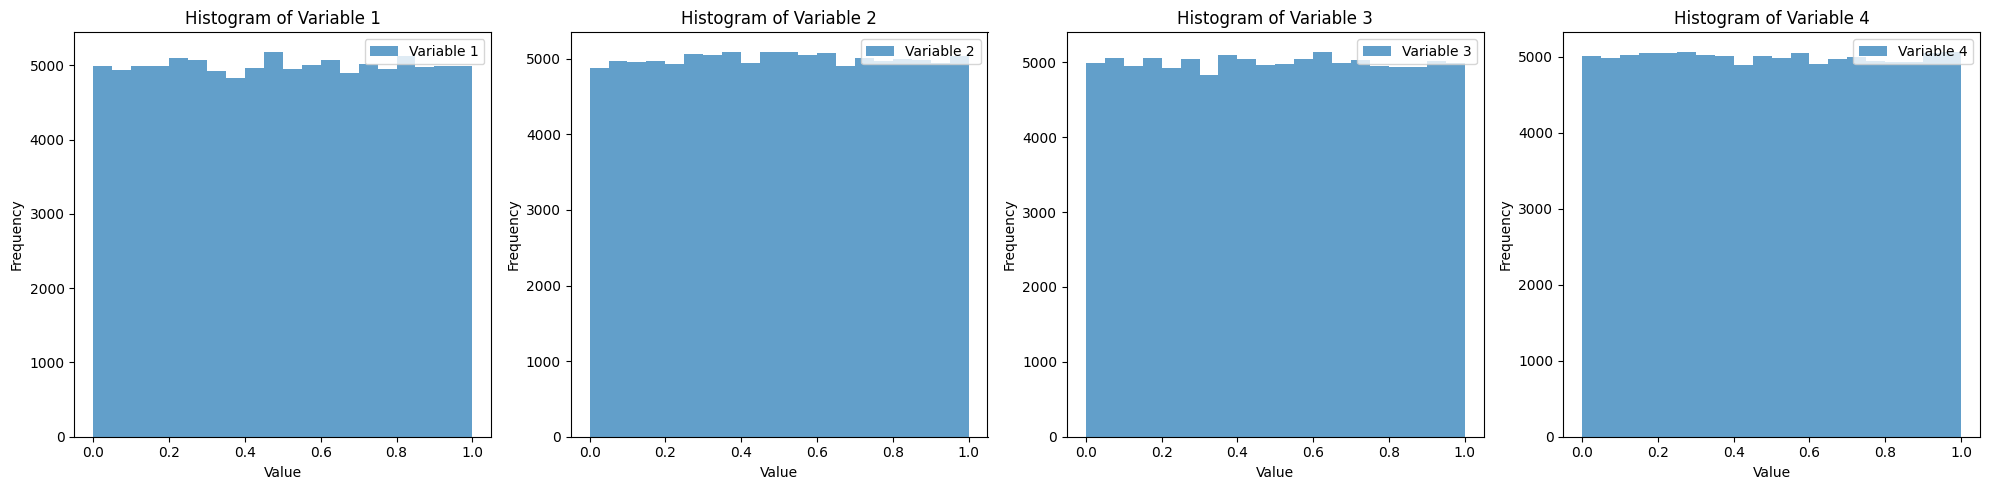

In [7]:
gk_dist.plot_observation(train_data_norm, num_samples =1)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 4
latent_dim = 20
conditional_dim = 1000
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048]
activation_fn = nn.ELU()

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=0.1,
)

optimizer = optim.AdamW(network.parameters(), lr=1e-5)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)

network.tune_hyperparameters(train_loader = train_loader, 
                             validation_loader = validation_loader)

2024-02-19 13:26:35,954	INFO worker.py:1724 -- Started a local Ray instance.
2024-02-19 13:26:36,425	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-02-19 13:26:38,140	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2024-02-19 13:26:38,141	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


ValueError: Tracked actor is not managed by this event manager: <TrackedActor 245189575518065535221749376178103879261>

In [ ]:
print(network)

In [ ]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= gk_dist.simulator)

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=1000)
post = theta_normalizer.inverse_transform(post)


In [ ]:
gk_dist.plot_posterior(post)

In [ ]:
gk_dist.posterior_hist(post)